In [68]:
import torch
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset

import EWOthello.utils.plot_helpers as plt_util
from EWOthello.data.othello import *
from EWOthello.mingpt.dataset import ProbingDataset, CharDataset # AK's mingpt data child 
from EWOthello.mingpt.model import GPT, GPTConfig, GPTforProbing # AKs and KLi GPT models
#from EWOthello.mingpt.trainer import Trainer, TrainerConfig # AKs GPT trainer
from EWOthello.mingpt.probe_trainer import Trainer, TrainerConfig
from EWOthello.mingpt.utils import set_seed, sample # AKs helpers for sampling predictions
from EWOthello.mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer
set_seed(44)

In [57]:
othello = get(ood_num=int(1e3), data_root=None)
train_dataset = CharDataset(othello) 

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

100%|██████████| 1000/1000 [00:02<00:00, 392.65it/s]


Dataset created has 1000 sequences, 61 unique words.


In [58]:
# This is a truncated GPT model (with random or pre-trained weights) that will be used to get activations from after attention modules
# you can define if we want layernorm applied at output or not (defaults to not)
model_probe = GPTforProbing(mconf, probe_layer=2)

mode = "synthetic"
# Apply the GPT model weights
if mode=="random":
    model_probe.apply(model._init_weights)
else:
    path = "../EWOthello/ckpts/gpt_championship.ckpt" if mode=="championship" else "../EWOthello/ckpts/gpt_synthetic.ckpt"
    model_probe.load_state_dict(torch.load(path))

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model_probe = model_probe.to(device)

In [59]:
x, y = train_dataset[0]
x = torch.unsqueeze(x, 0)

model_out_logits = model(x.to(device))[0]
print(model_out_logits.shape)

probe_activation = model_probe(x.to(device))
print(probe_activation.shape)

torch.Size([1, 59, 61])
torch.Size([1, 59, 512])


1
59


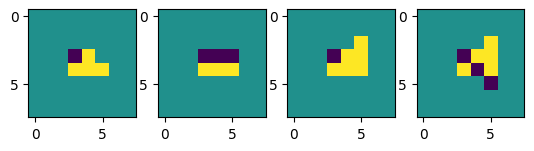

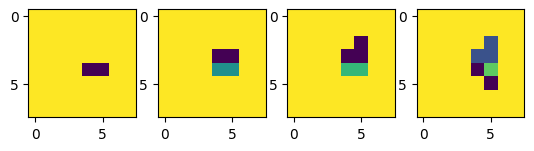

In [60]:
## mini-example before getting to the main part

# Grab a single game sequence index vector x
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
it = iter(loader)
x,_ = next(it)

act_container = []
property_container = []

# Note the sequence length and get tbf = index to tokens
tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
valid_until = tbf.index(-100) if -100 in tbf else 999 # Get true length of game sequence (excluding filler token -100) 
# I dont think this valid_until treatment is correct but okay...

# Get the activation output features
act = model_probe(x.to(device))[0].detach().cpu()  # [block_size, f]
act = [_[0] for _ in act.split(1, dim=0)[:valid_until]]  # list of activations after the n-th layer block
print(len(act))
act_container.extend(act)

# Get the board state
a = OthelloBoardState()
properties = a.get_gt(tbf[:valid_until], "get_state") 
property_container.extend(properties)
print(len(properties)) # list of 8*8 boardstates for each subsequence up until the full sequence length
num = 4
fig = plt.figure()
ax = plt_util.addAxis(fig, 1,num)
for i in range(num):
    board = np.reshape(np.array(properties[i]), [8,8])
    ax[i].imshow(board)

# Get the "age"
a = OthelloBoardState()
ages = a.get_gt(tbf[:valid_until], "get_age")  # [block_size, ]
fig = plt.figure()
ax = plt_util.addAxis(fig, 1,num)
for i in range(num):
    out = np.reshape(np.array(ages[i]), [8,8])
    ax[i].imshow(out)
plt.show()

In [64]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []
for x, y in tqdm(loader, total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]] # Index to string (converts the sequence to board state)
    valid_until = tbf.index(-100) if -100 in tbf else 999
    a = OthelloBoardState()
    properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
    
    act = model_probe(x.to(device))[0].detach().cpu()  # [block_size, f]
    act_container.extend([_[0] for _ in act.split(1, dim=0)[:valid_until]])
    property_container.extend(properties)

age_container = []
for x, y in tqdm(loader, total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    valid_until = tbf.index(-100) if -100 in tbf else 999
    a = OthelloBoardState()
    ages = a.get_gt(tbf[:valid_until], "get_age")  # [block_size, ]
    age_container.extend(ages)


100%|██████████| 1000/1000 [00:03<00:00, 282.99it/s]


59000 59000


100%|██████████| 1000/1000 [00:01<00:00, 545.90it/s]


In [65]:
probing_dataset = ProbingDataset(act_container, property_container, age_container)
probe = BatteryProbeClassification(device, probe_class=3, num_task=64)

# probing dataset returns activation, y, and age
# Porbe at the dataloader
it = iter(probing_dataset)
act, y, age = next(it)

print(act.shape)
print(len(act), len(y), len(age))

59000 pairs loaded...
983159 1770000 1022841
[189577, 223213, 217427, 191617, 186641, 165972, 161663, 144914, 141064, 127430, 124000, 112471, 109375, 99693, 96799, 88768, 86170, 79419, 76972, 71012, 68751, 63683, 61570, 57135, 55208, 51450, 49606, 46364, 44672, 41859, 40265, 37714, 36183, 33910, 32449, 30398, 28992, 27164, 25799, 24111, 22795, 21269, 20025, 18623, 17407, 16065, 14931, 13687, 12576, 11414, 10285, 9180, 8122, 7073, 6036, 5015, 4010, 3004, 2003, 1000]
torch.Size([512])
512 64 64


In [70]:
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
sampler = None
train_loader = DataLoader(train_dataset, shuffle=False, sampler=sampler, pin_memory=True, batch_size=128, num_workers=1)
test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True, batch_size=128, num_workers=1)

savepath = "../EWOthello/ckpts/"
max_epochs = 50
t_start = time.strftime("_%Y%m%d_%H%M%S")
tconf = TrainerConfig(
    max_epochs=max_epochs,
    batch_size=1024,
    learning_rate=1e-3,
    betas=(0.9, 0.999),
    lr_decay=True,
    warmup_tokens=len(train_dataset) * 5,
    final_tokens=len(train_dataset) * max_epochs,
    num_workers=4,
    weight_decay=0.0,
    ckpt_path=savepath + f"probe_test_at{t_start}.ckpt", 
)
trainer = Trainer(probe, train_dataset, test_dataset, tconf)
trainer.train(prt=True)
trainer.save_traces()
trainer.save_checkpoint()


Decayed: {'proj.bias', 'proj.weight'}


epoch 1: train loss 0.36498; lr 1.00e-03; train acc 77.67%: 100%|██████████| 47/47 [00:00<00:00, 69.38it/s]
epoch 2: train loss 0.36259; lr 1.00e-03; train acc 77.86%: 100%|██████████| 47/47 [00:00<00:00, 74.06it/s]
epoch 3: train loss 0.36206; lr 7.50e-04; train acc 77.95%: 100%|██████████| 47/47 [00:00<00:00, 72.62it/s]
epoch 4: train loss 0.36146; lr 5.63e-04; train acc 78.03%: 100%|██████████| 47/47 [00:00<00:00, 77.63it/s]
epoch 5: train loss 0.36014; lr 4.22e-04; train acc 78.08%: 100%|██████████| 47/47 [00:00<00:00, 73.67it/s]
epoch 6: train loss 0.36004; lr 3.16e-04; train acc 78.12%: 100%|██████████| 47/47 [00:00<00:00, 75.81it/s]
epoch 7: train loss 0.35921; lr 2.37e-04; train acc 78.15%: 100%|██████████| 47/47 [00:00<00:00, 73.38it/s]
epoch 8: train loss 0.36026; lr 1.78e-04; train acc 78.17%: 100%|██████████| 47/47 [00:00<00:00, 73.11it/s]
epoch 9: train loss 0.36032; lr 1.33e-04; train acc 78.18%: 100%|██████████| 47/47 [00:00<00:00, 77.03it/s]
epoch 10: train loss 0.35878